# Cluster AE experiments by waveform correlation

In [2]:
import gc
gc.collect()

17

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy.signal import resample, fftconvolve

import pandas as pd
import numpy as np
import h5py

import time
#from h5glance import H5Glance
import gc

import multiprocessing
from joblib import Parallel, delayed
import Helper_Utils as he
import seaborn as sns

In [4]:
import os
import seaborn as sns
import matplotlib as mpl

import Helper_Utils as he
import importlib as oe
#oe.reload(he)
he.set_plot_prop()

In [5]:
data_cat_Dry = pd.read_csv("../../00_Data/Dry_Basalt/dry_events_with_mechdata_AppendedMechanical_1min.csv")
data_cat_Wet = pd.read_csv("../../00_Data/Wet_Basalt/wet_events_with_mechdata_AppendedMechanical_1min.csv")
data_cat_Dry_Ar = pd.read_csv("../../00_Data/Dry_Basalt_Ar/dryargon_events_with_mechdata_AppendedMechanical_1min.csv")
data_cat_CO2 = pd.read_csv("../../00_Data/Wet_Basalt_CO2/co2_events_with_mechdata_AppendedMechanical_1min.csv")
data_cat_CO2_B = pd.read_csv("../../00_Data/Wet_Basalt_CO2_B/or3b_events_with_mechdata_AppendedMechanical_1min.csv")

In [6]:
data_cat_Dry['evID'] = data_cat_Dry['evID'].astype('str')
data_cat_Dry['Exp_Name'] = str(data_cat_Dry.index.values*0)
data_cat_Dry['Exp_Name'] = 'Dry'

data_cat_Wet['evID'] = data_cat_Wet['evID'].astype('str')
data_cat_Wet['Exp_Name'] = str(data_cat_Wet.index.values*0)
data_cat_Wet['Exp_Name'] = 'Wet'

data_cat_Dry_Ar['evID'] = data_cat_Dry_Ar['evID'].astype('str')
data_cat_Dry_Ar['Exp_Name'] = str(data_cat_Dry_Ar.index.values*0)
data_cat_Dry_Ar['Exp_Name'] = 'Dry_Ar'

data_cat_CO2['evID'] = data_cat_CO2['evID'].astype('str')
data_cat_CO2['Exp_Name'] = str(data_cat_CO2.index.values*0)
data_cat_CO2['Exp_Name'] = 'CO2_H2O'

data_cat_CO2_B['evID'] = data_cat_CO2_B['evID'].astype('str')
data_cat_CO2_B['Exp_Name'] = str(data_cat_CO2_B.index.values*0)
data_cat_CO2_B['Exp_Name'] = 'CO2_H2O_Open'


In [7]:
plt.plot(data_cat_CO2_B.P_confining,data_cat_CO2_B.P_fluid)

In [8]:
# plt.plot(data_cat_Dry.Sig_diff_MPa,'-')

In [9]:
import scipy.signal as scs
from scipy.stats import entropy

def waveform_energy(waveform,method):
    # amplitude envelope way (but this is not really energy units)
    if method=='hilbert_env':
        waveform_env = np.abs(scs.hilbert(waveform))
        waveform_env_n = waveform_env/np.max(waveform_env)
        enrgy = np.sum(waveform_env)/len(waveform_env_n)
    if method=='abssquared':
        waveform_env = (np.abs(waveform))**2
        waveform_env_n = waveform_env/np.max(waveform_env)
        enrgy = np.sum(waveform_env)
    return enrgy, entropy(waveform_env_n/np.sum(waveform_env_n))


In [10]:
## Number of points to resample the waveforms to 
resampl_size = 1000 

# Combine all waveforms into one file in order to run specufex on all
# first extract the data from each individual spectrogram h5

evIDs = []
waveforms = []
normconst = []
experiment = []
catalog = pd.DataFrame()

evIDs_cat = []
evIDs = []
evIDs = []
enrgy_all = []
entropy_all = []

files = [
      "../../00_Data/Dry_Basalt/data_Dry_AEs.h5",
      "../../00_Data/Wet_Basalt/data_wet_AEs.h5",
      "../../00_Data/Dry_Basalt_Ar/data_bs_dry.h5",
     "../../00_Data/Wet_Basalt_CO2/data_co2_AEs.h5",
    "../../00_Data/Wet_Basalt_CO2_B/data_or3b_aes.h5",
]

# f = h5py.File(files[0], "r")
# f['waveforms/pzt01'].keys()

for file in files:
    print(file)
    with h5py.File(file, "r") as f:
        try:
            evIDs_ = list(f["waveforms/1/na"].keys())
            for evID in evIDs_:
                waveform = resample(f["waveforms/1/na"][evID][()], resampl_size)
                
                enrgy, entrpy = waveform_energy(waveform,'abssquared')
                waveforms.append(waveform)
                exp_name = file.split("_")[-2]
                if exp_name == "OR2": exp_name="CO2+water"
                if exp_name == "bs": exp_name="dry_argon"
                experiment.append(exp_name)
                enrgy_all.append(enrgy)
                entropy_all.append(entrpy)
            evIDs += evIDs_
        except:
            try:
                evIDs_ = list(f["waveforms/pzt01/ch01"].keys())
                for evID in evIDs_:
                    waveform = resample(f["waveforms/pzt01/ch01"][evID][()],resampl_size )
                    enrgy, entrpy = waveform_energy(waveform,'abssquared')
                    waveforms.append(waveform)
                    exp_name = file.split("_")[-2]
                    if exp_name == "OR2": exp_name="CO2+water"
                    if exp_name == "bs": exp_name="dry_argon"
                    experiment.append(exp_name)
                    enrgy_all.append(enrgy)
                    entropy_all.append(entrpy)
                evIDs += evIDs_
            except:
                try :
                    evIDs_ = list(f["waveforms/pzt01/01"].keys())
                    for evID in evIDs_:
                        waveform = resample(f["waveforms/pzt01/01"][evID][()], resampl_size)
                        enrgy, entrpy = waveform_energy(waveform,'abssquared')
                        waveforms.append(waveform)
                        exp_name = file.split("_")[-2]
                        if exp_name == "OR2": exp_name="CO2+water"
                        if exp_name == "bs": exp_name="dry_argon"
                        experiment.append(exp_name)
                        enrgy_all.append(enrgy)
                        entropy_all.append(entrpy)
                    evIDs += evIDs_
                except:
                    evIDs_ = list(f["waveforms/pzt01/1"].keys())
                    for evID in evIDs_:
                        waveform = resample(f["waveforms/pzt01/1"][evID][()],resampl_size )
                        enrgy, entrpy = waveform_energy(waveform,'abssquared')
                        waveforms.append(waveform)
                        exp_name = file.split("_")[-2]
                        if exp_name == "or3b": exp_name="CO2_water_Open"
                        experiment.append(exp_name)
                        enrgy_all.append(enrgy)
                        entropy_all.append(entrpy)
                    evIDs += evIDs_
    
    #         df_ = pd.DataFrame()
    #         try:
    #             print(f["catalog/cat_by_sta/pzt01"].keys())
    #             for col in f["catalog/cat_by_sta/pzt01"].keys():
    #                 df_[col] = f["catalog/cat_by_sta/pzt01"][col][()].astype(str)
    #         except:
    #             try :
    #                 print(f["catalog/cat_by_sta/"].keys())
    #                 for col in f["catalog/cat_by_sta/1"].keys():
    #                     df_[col] = f["catalog/cat_by_sta/1"][col][()]
    #                     df_.rename(columns={"ev_ID": "event_ID"},inplace=True)
    #             except :
    #                 print(f["catalog/"].keys())
    #                 for col in f["catalog/"].keys():
    #                     df_[col] = f["catalog/"][col][()]
    #         catalog = pd.concat([catalog, df_])



../../00_Data/Dry_Basalt/data_Dry_AEs.h5
../../00_Data/Wet_Basalt/data_wet_AEs.h5
../../00_Data/Dry_Basalt_Ar/data_bs_dry.h5
../../00_Data/Wet_Basalt_CO2/data_co2_AEs.h5
../../00_Data/Wet_Basalt_CO2_B/data_or3b_aes.h5


In [11]:
## Check if the waveform size is correct (will error if not)
assert(len(waveforms[0]) == resampl_size)
len(waveforms)

28857

In [12]:
evIDs_int = [i for i in evIDs] 
df = pd.DataFrame({"evIDs":evIDs_int,'entropy':entropy_all,'energy':enrgy_all})
df['index_Waveforms_List'] = df.index.values

In [13]:
# data_cat_CO2_B = pd.read_csv("../../00_Data/Wet_Basalt_CO2_B/or3b_events_with_mechdata_AppendedMechanical_1min.csv")
# data_cat_CO2_B['evID'] = np.floor(data_cat_CO2_B['evID']).astype('int')
#evIDs_int = [int(i) for i in evIDs] 
df_merged_Dry = data_cat_Dry.merge(df, right_on='evIDs', left_on='evID')
df_merged_Dry_Ar = data_cat_Dry_Ar.merge(df, right_on='evIDs', left_on='evID')
df_merged_CO2 = data_cat_CO2.merge(df, right_on='evIDs', left_on='evID')
df_merged_CO2_B = data_cat_CO2_B.merge(df, right_on='evIDs', left_on='evID')
df_merged_Wet = data_cat_Wet.merge(df, right_on='evIDs', left_on='evID')

df_merged_Wet['log_energy'] = np.log10(df_merged_Wet['energy']/df_merged_Wet['energy'].max())
df_merged_Dry_Ar['log_energy'] = np.log10(df_merged_Dry_Ar['energy']/df_merged_Dry_Ar['energy'].max())
df_merged_CO2['log_energy'] = np.log10(df_merged_CO2['energy']/df_merged_CO2['energy'].max())
df_merged_CO2_B['log_energy'] = np.log10(df_merged_CO2_B['energy']/df_merged_CO2_B['energy'].max())
df_merged_Dry['log_energy'] = np.log10(df_merged_Dry['energy']/df_merged_Dry['energy'].max())


In [14]:
df_merged = pd.concat([df_merged_Dry,df_merged_CO2,df_merged_CO2_B,df_merged_Wet,df_merged_Dry_Ar])
df_merged.reset_index(inplace=True)


In [15]:
df_merged['date'] = pd.to_datetime(df_merged['timestamp'])
experiment_IDs = df_merged['Exp_Name'].values
df_merged['Index_Exp'] = df_merged.index.values
df_merged['log_energy_All'] = np.log10(df_merged['energy']/df_merged['energy'].max())
max_val = waveforms[0].shape[0] ## Should be the resampl_size
print(f'Total_Max_Length : {max_val}')

Total_Max_Length : 1000


In [16]:
exp_count = df_merged.groupby('Exp_Name')['Exp_Name'].count()
print(exp_count)
exp_indx = exp_count.index.values
exp_num  = exp_count.values*0. + resampl_size
exp_num = exp_num.astype(int)

num_events = dict(zip(exp_indx,exp_num))

Exp_Name
CO2_H2O           615
CO2_H2O_Open     8775
Dry              5365
Dry_Ar           1685
Wet             11188
Name: Exp_Name, dtype: int64


In [17]:
num_events

{'CO2_H2O': 1000,
 'CO2_H2O_Open': 1000,
 'Dry': 1000,
 'Dry_Ar': 1000,
 'Wet': 1000}

In [18]:
df_merged.columns

Index(['level_0', 'date', 'index', 'timestamp', 'evID', 'Disp_mm',
       'Sig_diff_MPa', 'Strain_ax', 'Temp', 'time_hr', 'count', 'Disp_mm_1min',
       'Sig_diff_MPa_1min', 'Strain_ax_1min', 'Temp_1min', 't_def',
       'time_hr_1min', 'Time_Since_Step_1', 'Time_Since_Step_2',
       'Time_Since_Step_3', 'Time_Since_Step_4', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate', 'Exp_Name', 'evIDs', 'entropy',
       'energy', 'index_Waveforms_List', 'log_energy', 'Unnamed: 0',
       'P_confining', 'P_fluid', 'P_confining_1min', 'P_fluid_1min',
       'Time_Since_Step_5', 'Time_Since_Step_6', 'Time_Since_Step_7',
       'Time_Since_Step_8', 'Time_Since_Step_9', 'Time_Since_Step_10',
       'Time_Since_Step_11', 'Time_Since_Step_12', 'Index_Exp',
       'log_energy_All'],
      dtype='object')

In [19]:
plt.plot(np.log10(df_merged['energy']/df_merged['energy'].max()))

In [20]:
plt.plot(entropy_all)

In [21]:
gc.collect()

85

In [22]:
df_cluster_specufex_Wet = pd.read_csv('../../00_Data/clusters-Fingerprint/clusters/wet_AEs.h5_clusters.csv')
df_cluster_specufex_Dry = pd.read_csv('../../00_Data/clusters-Fingerprint/clusters/dry_AEs.h5_clusters.csv')
df_cluster_specufex_Dry_bs = pd.read_csv('../../00_Data/clusters-Fingerprint/clusters/bs_dry.h5_clusters.csv')
df_cluster_specufex_Co2 = pd.read_csv('../../00_Data/clusters-Fingerprint/clusters/co2_AEs.h5_clusters.csv')

df_cluster_specufex_Co2['ev_ID'] = df_cluster_specufex_Co2['ev_ID'].astype('str')
df_cluster_specufex_Dry_bs['ev_ID'] = df_cluster_specufex_Dry_bs['ev_ID'].astype('str')
df_cluster_specufex_Dry['ev_ID'] = df_cluster_specufex_Dry['ev_ID'].astype('str')
df_cluster_specufex_Wet['ev_ID'] = df_cluster_specufex_Wet['ev_ID'].astype('str')

df_cluster_specufex_Wet.drop(df_cluster_specufex_Wet.columns[0], axis=1, inplace=True)
df_cluster_specufex_Dry.drop(df_cluster_specufex_Dry.columns[0], axis=1, inplace=True)
df_cluster_specufex_Dry_bs.drop(df_cluster_specufex_Dry_bs.columns[0], axis=1, inplace=True)
df_cluster_specufex_Co2.drop(df_cluster_specufex_Co2.columns[0], axis=1, inplace=True)


In [23]:
df_cluster_specufex_Orig = pd.read_csv('../../00_Data/clusters-Fingerprint/all_AEs_clusters.csv')
df_cluster_specufex_Orig['ev_ID'] = df_cluster_specufex_Orig['ev_ID'].astype('str')
df_cluster_specufex_Orig.drop(df_cluster_specufex_Orig.columns[0], axis=1, inplace=True)


In [24]:
df_cluster_specufex = df_cluster_specufex_Orig.merge(df_cluster_specufex_Wet, right_on='ev_ID', left_on='ev_ID',
                                                    suffixes =['','_Wet'],how='outer')
df_cluster_specufex = df_cluster_specufex.merge(df_cluster_specufex_Dry, right_on='ev_ID', left_on='ev_ID',
                                                    suffixes =['','_Dry'],how='outer')
df_cluster_specufex = df_cluster_specufex.merge(df_cluster_specufex_Co2, right_on='ev_ID', left_on='ev_ID',
                                                    suffixes =['','_CO2_H2O'],how='outer')
df_cluster_specufex = df_cluster_specufex.merge(df_cluster_specufex_Dry_bs, right_on='ev_ID', left_on='ev_ID',
                                                    suffixes =['','_Dry_Ar'],how='outer')

df_cluster_specufex

,ev_ID,NC_2,NC_3,NC_4,NC_5,NC_6,NC_7,NC_8,NC_2_Wet,NC_3_Wet,...,NC_6_CO2_H2O,NC_7_CO2_H2O,NC_8_CO2_H2O,NC_2_Dry_Ar,NC_3_Dry_Ar,NC_4_Dry_Ar,NC_5_Dry_Ar,NC_6_Dry_Ar,NC_7_Dry_Ar,NC_8_Dry_Ar
0,1001843,0,1,2,4,1,3,4,NaN,NaN,...,NaN,NaN,NaN,0.0,2.0,3.0,2.0,3.0,1.0,7.0
1,1005733,0,1,2,4,1,3,0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,2.0,0.0,0.0,3.0,0.0
2,1009435,0,1,2,4,1,3,0,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,0.0,1.0,5.0,0.0,4.0
3,101488930,0,1,2,4,1,3,0,NaN,NaN,...,NaN,NaN,NaN,0.0,2.0,3.0,2.0,3.0,1.0,7.0
4,102188492,0,1,2,4,1,0,5,NaN,NaN,...,NaN,NaN,NaN,1.0,2.0,1.0,4.0,1.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20061,99042180,0,1,2,4,1,3,0,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,0.0,4.0,1.0,4.0,2.0
20062,99051756,0,1,2,4,1,3,0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,2.0,0.0,0.0,3.0,3.0
20063,99566000,0,1,2,4,1,3,0,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,2.0,0.0,2.0,5.0,1.0
20064,997415,1,0,0,2,0,2,6,NaN,NaN,...,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_merged_WithClust = df_merged.merge(df_cluster_specufex, right_on='ev_ID', left_on='evID')


In [26]:
df_merged_WithClust

,level_0,date,index,timestamp,evID,Disp_mm,Sig_diff_MPa,Strain_ax,Temp,time_hr,...,NC_6_CO2_H2O,NC_7_CO2_H2O,NC_8_CO2_H2O,NC_2_Dry_Ar,NC_3_Dry_Ar,NC_4_Dry_Ar,NC_5_Dry_Ar,NC_6_Dry_Ar,NC_7_Dry_Ar,NC_8_Dry_Ar
0,0,2020-01-09 14:40:33.000000000,106,1578580833000000000,2020.009.624033.225633151,1.51828,8.762600,0.000331,78.2065,0.025833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-01-09 14:40:53.000000000,107,1578580853000000000,2020.009.624053.225653637,1.52536,9.524600,0.000423,78.2065,0.031389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-01-09 14:42:59.000000000,108,1578580979000000000,2020.009.624259.225779480,1.55790,13.334400,0.000845,78.2429,0.066389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2020-01-09 14:43:07.000000000,109,1578580987000000000,2020.009.624307.225787413,1.55790,13.334400,0.000845,78.1701,0.068611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2020-01-09 14:44:52.000000000,110,1578581092000000000,2020.009.624452.225892618,1.58337,16.763300,0.001176,78.1701,0.097778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18848,1680,1970-01-01 00:00:00.000258300,1680,258300,258300650,6.19624,5.679400,0.080158,NaN,71.625000,...,NaN,NaN,NaN,0.0,2.0,3.0,2.0,3.0,1.0,7.0
18849,1681,1970-01-01 00:00:00.000258301,1681,258301,258301493,6.19624,5.679400,0.080158,NaN,71.625278,...,NaN,NaN,NaN,0.0,2.0,3.0,2.0,3.0,1.0,7.0
18850,1682,1970-01-01 00:00:00.000258305,1682,258305,258305617,6.19482,5.679400,0.080140,NaN,71.626389,...,NaN,NaN,NaN,1.0,1.0,1.0,3.0,1.0,0.0,1.0
18851,1683,1970-01-01 00:00:00.000258307,1683,258307,258307101,6.19482,5.679400,0.080140,NaN,71.626944,...,NaN,NaN,NaN,0.0,2.0,1.0,3.0,2.0,5.0,3.0


In [27]:
exp_count = df_merged_WithClust.groupby('Exp_Name')['Exp_Name'].count()
print(exp_count)


Exp_Name
CO2_H2O      615
Dry         5365
Dry_Ar      1685
Wet        11188
Name: Exp_Name, dtype: int64


Original was this :

Exp_Name
CO2_H2O           615

CO2_H2O_Open     8775

Dry              5262

Dry_Ar           1685

Wet             11188

In [28]:
df_merged_WithClust.to_csv('A0_Results/df_merged_WithClust.csv')

In [29]:
df_merged = df_merged_WithClust

### Resort the waveforms to be time ordered!

In [30]:
index_list = df_merged['index_Waveforms_List'].values.tolist()
waveforms_subset = []
for wave in [waveforms[i] for i in index_list]:
    waveforms_subset.append(wave)

waveforms = waveforms_subset

In [31]:
len(waveforms)

18853

In [32]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler,MaxAbsScaler,StandardScaler
#scaler = MinMaxScaler((-1,1))
#scaler = RobustScaler()
#scaler = StandardScaler()
scaler = MaxAbsScaler()


#scaler.fit(np.transpose(waveforms))
scaler.fit(np.transpose(waveforms- np.mean(waveforms, axis=1)[:,np.newaxis]))
norm_waveforms = np.transpose(scaler.transform(np.transpose(waveforms)))
#norm_waveforms = norm_waveforms - np.mean(norm_waveforms, axis=1)[:,np.newaxis]

### Manual normalization .. 
## norm_waveforms = (waveforms/np.max(np.abs(waveforms), axis=1)[:,np.newaxis])


In [33]:
# visualize the input dataset as separate objects

plt.figure(1, figsize=(15, 20))
plt.title("Norm dataset")
for i, object_data in enumerate(waveforms[0:5]):
    object_data_scaled_y = object_data/object_data.max() + i*2 # scale the objects so they will not be one on top of the other
    plt.plot(object_data_scaled_y, "k",alpha=0.6)
    
plt.xlabel("x")
plt.ylabel("scaled intensity")

plt.tight_layout()

In [34]:
df_merged['Index_Exp'] = df_merged.index.values

In [35]:
path_to_save = 'A0_Results/Cross_Corr_Distance_New'
try : 
    os.mkdir(path_to_save)
except :
    print('exits')
path_to_save += '/'


exits


In [36]:
path_to_save

'A0_Results/Cross_Corr_Distance_New/'

In [37]:
he.set_plot_prop()

# visualize the input dataset 
for exp in np.unique(df_merged['Exp_Name'].values) :
    indx = df_merged.loc[df_merged['Exp_Name'] == exp,'Index_Exp'].values
    print(np.diff(indx).max(),np.diff(indx).min())
    plt.figure(figsize=(15, 14))
    plt.title(f"Input dataset : {exp}")
    plt.pcolormesh(norm_waveforms[indx].T,cmap=plt.cm.RdBu)
    plt.colorbar(label='Normalized Amplitude')
    plt.ylabel("Waveform Time")
    plt.xlabel("AE Count")
    plt.savefig(path_to_save+exp+'/Time_Series_Waveform_Plots.png')
    plt.tight_layout()

# visualize the input dataset 
for exp in np.unique(df_merged['Exp_Name'].values) :
    indx = df_merged.loc[df_merged['Exp_Name'] == exp,'Index_Exp'].values
    print(np.diff(indx).max(),np.diff(indx).min())
    plt.figure(figsize=(15, 14))
    plt.title(f"Input dataset : {exp}")
    plt.pcolormesh(norm_waveforms[indx],cmap=plt.cm.RdBu)
    plt.colorbar(label='Normalized Amplitude')
    plt.xlabel("Waveform Time")
    plt.ylabel("AE Count")
    plt.savefig(path_to_save+exp+'/Time_Series_Waveform_Plots_Flipped.png')
    plt.tight_layout()

plt.close('all')

1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1


In [38]:
he.set_plot_prop()

# visualize the input dataset 
for exp in np.unique(df_merged['Exp_Name'].values) :
    indx = df_merged.loc[df_merged['Exp_Name'] == exp,'Index_Exp'].values
    print(np.diff(indx).max(),np.diff(indx).min())
    plt.figure(figsize=(15, 14))
    plt.title(f"Input dataset : {exp}")
    plt.pcolormesh(df_merged['time_hr'].values[indx],np.arange(0,resampl_size,1),norm_waveforms[indx].T,cmap=plt.cm.RdBu)
    plt.colorbar(label='Normalized Amplitude')
    plt.ylabel("Waveform Time")
    plt.xlabel("Experiment Time (hr)")
    plt.tight_layout()
    #indx_AE_vals_use = np.arange(0,indx.shape[0],int(indx.shape[0]/10))
    #plt.xticks(indx_AE_vals_use,[indx_AE_vals_use])
    plt.savefig(path_to_save+exp+'/Time_Series_Waveform_Plots_InTime.png')

plt.close('all')

1 1
1 1
1 1
1 1


In [77]:
method_use = 'Kmeans_SpecuFEx'
n_clust= 5 # if starting from 0 subtract 1 from actual num of clusters
use_global = False

for exp_ID in np.unique(experiment_IDs):
    if use_global :
        cluster_name = f'NC_{n_clust+1}'    
    else :
        cluster_name = f'NC_{n_clust+1}_{exp_ID}'
    print(exp_ID,cluster_name)
    time_vals = np.arange(0,num_events[exp_ID],resample_val)
    index_list,waveforms_subset = he.get_subset_waveforms_byexp(norm_waveforms,
                                                                    exp_ID,df_merged,set_max_val=True,select_subset=False,
                                                                 max_val_wave= num_events[exp_ID],sample_rate=resample_val)
    evIDs_int  = index_list.copy()
    length_waveforms = waveforms_subset[0].shape[0]
    df_merged_sub = df_merged.loc[df_merged['Index_Exp'].isin(evIDs_int),:]

    he.get_representative_waveforms(cluster_name,norm_waveforms,time_vals,n_clust,
                                    df_merged_sub,
                                    index_list,
                                    num_events=40,cross_corr=False,
                                    max_time_indx=length_waveforms,
                                    max_val_time_wave=length_waveforms,
                                    resample_rate=1,start_clust=0,
                                                               exp_name=exp_ID)
    plt.figure(10)
    if use_global :
        plt.savefig(path_to_save+exp_ID+f"/{method_use}_Cluster_Waveforms_Original_Global_Clust{n_clust+1}.png")
    else :
        plt.savefig(path_to_save+exp_ID+f"/{method_use}_Cluster_Waveforms_Original_Indiv_Exp_Clust{n_clust+1}.png")
    plt.figure(11)
    plt.close('all')
    print(df_merged_sub.groupby(cluster_name)[cluster_name].count())
    

CO2_H2O NC_6_CO2_H2O
NC_6_CO2_H2O
0.0    148
1.0    164
2.0     19
3.0     91
4.0    191
5.0      2
Name: NC_6_CO2_H2O, dtype: int64
Dry NC_6_Dry
NC_6_Dry
0.0    1166
1.0    1130
2.0    1148
3.0     449
4.0     781
5.0     691
Name: NC_6_Dry, dtype: int64
Dry_Ar NC_6_Dry_Ar
NC_6_Dry_Ar
0.0    321
1.0    434
2.0    369
3.0    277
4.0     48
5.0    236
Name: NC_6_Dry_Ar, dtype: int64
Wet NC_6_Wet
NC_6_Wet
0.0    2361
1.0    2389
2.0    3310
3.0     291
4.0     901
5.0    1936
Name: NC_6_Wet, dtype: int64


## Cross Correlation

In [39]:
frac_allowed = 0.1 # max 10% shift of the total waveform length
resample_val = 1
df_merged.to_csv(path_to_save+'df_merged_base.csv')

In [40]:
gc.collect()

56538

In [41]:
experiment_IDs = df_merged['Exp_Name'].values

In [78]:
for exp_ID in np.unique(experiment_IDs):
    print(exp_ID)
    f1 = os.path.isfile(path_to_save+exp_ID+"/New_Processed_correlation_matrix.npy") 
    time_vals = np.arange(0,num_events[exp_ID],resample_val)
    index_list,waveforms_subset = he.get_subset_waveforms_byexp(norm_waveforms,
                                                                    exp_ID,df_merged,set_max_val=True,select_subset=False,
                                                                 max_val_wave= num_events[exp_ID],sample_rate=resample_val)
    try :
            os.mkdir(path_to_save+exp_ID)
    except:
            print('Exists')
    if f1 == False :
        A,A_time,A_summed = he.calc_corrmatrix(waveforms_subset,int(num_events[exp_ID]*frac_allowed))
        np.save(path_to_save+exp_ID+"/New_Processed_correlation_matrix.npy", A)
        np.save(path_to_save+exp_ID+"/New_Processed_correlation_matrix_TimeShift.npy", A_time)
        np.save(path_to_save+exp_ID+"/New_Processed_correlation_matrix_Summed.npy", A_summed)
        
    f2 = os.path.isfile(path_to_save+exp_ID+"/Distance_Matrix_L1.npy") 
    if f2 == False :
        A_L1 = he.calc_distmatrix_Basic_Distances(waveforms_subset,'l1',n_jobs=True)
        np.save(path_to_save+exp_ID+"/Distance_Matrix_L1.npy", A_L1)
        A_L2 = he.calc_distmatrix_Basic_Distances(waveforms_subset,'l2',n_jobs=True)
        np.save(path_to_save+exp_ID+"/Distance_Matrix_L2.npy", A_L2)
        A_cos = he.calc_distmatrix_Basic_Distances(waveforms_subset,'cosine',n_jobs=True)
        np.save(path_to_save+exp_ID+"/Distance_Matrix_cosine.npy", A_cos)
        A_cor = he.calc_distmatrix_Basic_Distances(waveforms_subset,'correlation',n_jobs=True)
        np.save(path_to_save+exp_ID+"/Distance_Matrix_correlation.npy", A_cor)        
gc.collect()

CO2_H2O
Exists
Dry
Exists
Dry_Ar
Exists
Wet
Exists


98959

In [79]:
df_merged.columns


Index(['level_0', 'date', 'index', 'timestamp', 'evID', 'Disp_mm',
       'Sig_diff_MPa', 'Strain_ax', 'Temp', 'time_hr', 'count', 'Disp_mm_1min',
       'Sig_diff_MPa_1min', 'Strain_ax_1min', 'Temp_1min', 't_def',
       'time_hr_1min', 'Time_Since_Step_1', 'Time_Since_Step_2',
       'Time_Since_Step_3', 'Time_Since_Step_4', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate', 'Exp_Name', 'evIDs', 'entropy',
       'energy', 'index_Waveforms_List', 'log_energy', 'Unnamed: 0',
       'P_confining', 'P_fluid', 'P_confining_1min', 'P_fluid_1min',
       'Time_Since_Step_5', 'Time_Since_Step_6', 'Time_Since_Step_7',
       'Time_Since_Step_8', 'Time_Since_Step_9', 'Time_Since_Step_10',
       'Time_Since_Step_11', 'Time_Since_Step_12', 'Index_Exp',
       'log_energy_All', 'ev_ID', 'NC_2', 'NC_3', 'NC_4', 'NC_5', 'NC_6',
       'NC_7', 'NC_8'

In [82]:
oe.reload(he)
he.set_plot_prop()
plt.close('all')

In [ ]:
plt.ion()
for exp_ID in np.unique(experiment_IDs)[3:4]:
    plt.close('all')

    print(exp_ID,num_events[exp_ID])
    time_vals = np.arange(0,num_events[exp_ID],resample_val)
    index_list,waveforms_subset = he.get_subset_waveforms_byexp(norm_waveforms,
                                                                exp_ID,df_merged,set_max_val=True,select_subset=False,
                                                             max_val_wave= num_events[exp_ID],sample_rate=resample_val)
    var1 = 'time_hr'
    #var2 = 'NC_6_'+exp_ID
    var2 = 'Sig_diff_MPa_1min'
    n_clust = 6
    methods_all = np.array(['ward'])

    var1_list = ['Strain_ax_1min','Sig_diff_MPa_1min','strain_rate','AE_rate_count','log_energy']
    var2_list = ['NC_8_'+exp_ID,'NC_7_'+exp_ID,'NC_6_'+exp_ID,'NC_5_'+exp_ID,'NC_4_'+exp_ID,'NC_3_'+exp_ID]

    evIDs_int  = index_list.copy()
    if exp_ID == 'Wet':
        evIDs_int = evIDs_int[::2]
        print('JERE2')
    length_waveforms = waveforms_subset[0].shape[0]
    
    A_L2 = np.load(path_to_save+exp_ID+f"/Distance_Matrix_L2.npy")
    A_L1 = np.load(path_to_save+exp_ID+f"/Distance_Matrix_L1.npy")
    A_cos = np.load(path_to_save+exp_ID+f"/Distance_Matrix_cosine.npy")
    A_corr = np.load(path_to_save+exp_ID+f"/Distance_Matrix_correlation.npy")
    A = np.load(path_to_save+exp_ID+f"/New_Processed_correlation_matrix.npy")
    A_time = np.load(path_to_save+exp_ID+f"/New_Processed_correlation_matrix_TimeShift.npy")
    A_summed = np.load(path_to_save+exp_ID+"/New_Processed_correlation_matrix_Summed.npy")

    df_merged_sub = df_merged.loc[df_merged['Index_Exp'].isin(evIDs_int),:]
    def make_Plot_Complement(A,df_merged_sub,name,A_time=None,cross_corr=False):
        try  :
            os.mkdir(path_to_save+exp_ID+name)
        except:
            print('exists')
        
        for method_use in methods_all :
            plt.close('all')
            #he.plot_matrix(df_merged,evIDs_int,var1,var2,A_time,np.median(A_time),num_values_side_bar=int(len(evIDs_int)/10))
            #plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Matrix_Atime_{var1}_{var2}.png")
            #he.plot_matrix(df_merged,evIDs_int,var1,var2,A,np.median(A),num_values_side_bar=int(len(evIDs_int)/10))
            #plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Matrix_{var1}_{var2}.png")
            print('Doing Clustering .. ')
            
            try : 
                linkage = np.load(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_Colorbar_Col.npy")
                print('JERE ..')
                g = he.plot_cluster(df_merged,evIDs_int,var1,var2,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=linkage,col_linkage=linkage)
            except :
                g = he.plot_cluster(df_merged,evIDs_int,var1,var2,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=None,col_linkage=None)
                np.save(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_Colorbar_Col.npy",g.dendrogram_col.linkage)
            
            print('DONE Clustering')
            plt.figure(10)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Col.png")
            plt.figure(11)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Row.png")
            g.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}.png")
            plt.close('all')

#             try : 
#                 linkage = np.load(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Col.npy")
#                 g = he.plot_cluster_Multi(df_merged,evIDs_int,var1_list,var2_list,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=linkage,col_linkage=linkage)
#             except :
#                 g = he.plot_cluster_Multi(df_merged,evIDs_int,var1_list,var2_list,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=None,col_linkage=None)
#                 np.save(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Col.npy",g.dendrogram_col.linkage)
#             g.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_Multiple_Variables.png")

            cluster_name = method_use+'_'+name.split("/")[1]
            print(name,method_use,cluster_name)

            df_merged_sub = he.get_clust(df_merged_sub,n_clust,g,
                                         path_to_save+exp_ID+name+f"/{method_use}_File_Cluster_Info.txt",
                                         cluster_name)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Matrix_Dendrogram.png")
            he.Plot_clust_time(cluster_name,df_merged_sub)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Time_Sequence.png")
            plt.close('all')

            he.make_plot_Dist(cluster_name,df_merged_sub,var1)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Wasserstein_{var1}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}.png")
            plt.close()

            he.make_plot_Dist(cluster_name,df_merged_sub,var2)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var2}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Wasserstein_{var2}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var2}.png")
            plt.close()
            he.make_plot_Cross(cluster_name,df_merged_sub,var1,var2)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}_{var2}.png")

            plt.close('all')
            he.get_representative_waveforms(cluster_name,norm_waveforms,time_vals,n_clust,df_merged_sub,index_list,num_events=40,
                                          cross_corr=cross_corr,time_shift_CrossCorr=A_time,
                                         max_time_indx=int(num_events[exp_ID]*1.1),
                                            max_val_time_wave=length_waveforms,
                                            resample_rate=resample_val,
                                            start_clust=1,exp_name=exp_ID)

            plt.figure(10)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Waveforms_Original.png")
            #plt.figure(11)
            #plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Waveforms_TimeShifted.png")
            plt.close('all')
            df_merged_sub.to_csv(path_to_save+exp_ID+name+f'/{method_use}_df_merged_sub.csv')
            gc.collect()
        return df_merged_sub

    if exp_ID == 'Wet':
        #df_merged_sub = make_Plot_Complement(A_L2[::2,::2],df_merged_sub,'/L2_Dist')
        #df_merged_sub = make_Plot_Complement(A_L1[::2,::2],df_merged_sub,'/L1_Dist')
        #df_merged_sub = make_Plot_Complement(A_cos[::2,::2],df_merged_sub,'/cos_Dist')
        #df_merged_sub = make_Plot_Complement(A_corr[::2,::2],df_merged_sub,'/corr_Dist')
        df_merged_sub = make_Plot_Complement(A[::2,::2],df_merged_sub,'/Cross_Corr_Dist',A_time=A_time[::2,::2],cross_corr=True)
    else :
        df_merged_sub = make_Plot_Complement(A_L2,df_merged_sub,'/L2_Dist')
        df_merged_sub = make_Plot_Complement(A_L1,df_merged_sub,'/L1_Dist')
        df_merged_sub = make_Plot_Complement(A_cos,df_merged_sub,'/cos_Dist')
        df_merged_sub = make_Plot_Complement(A_corr,df_merged_sub,'/corr_Dist')
        df_merged_sub = make_Plot_Complement(A,df_merged_sub,'/Cross_Corr_Dist',A_time=A_time,cross_corr=True)

    #df_merged_sub.to_csv(path_to_save+exp_ID+f'/df_merged_sub.csv')
        
#plt.close('all')
plt.ion()


Wet 1000
JERE2
exists
Doing Clustering .. 
JERE ..


In [68]:
plt.ion()
for exp_ID in np.unique(experiment_IDs)[3:]:
    plt.close('all')

    print(exp_ID,num_events[exp_ID])
    time_vals = np.arange(0,num_events[exp_ID],resample_val)
    index_list,waveforms_subset = he.get_subset_waveforms_byexp(norm_waveforms,
                                                                exp_ID,df_merged,set_max_val=True,select_subset=False,
                                                             max_val_wave= num_events[exp_ID],sample_rate=resample_val)
    var1 = 'time_hr'
    var2 = 'NC_6_'+exp_ID
    #var2 = 'Sig_diff_MPa_1min'
    n_clust = 6
    methods_all = np.array(['ward'])

    var1_list = ['Strain_ax_1min','Sig_diff_MPa_1min','strain_rate','AE_rate_count','log_energy']
    var2_list = ['NC_8_'+exp_ID,'NC_7_'+exp_ID,'NC_6_'+exp_ID,'NC_5_'+exp_ID,'NC_4_'+exp_ID,'NC_3_'+exp_ID]

    evIDs_int  = index_list.copy()
    if exp_ID == 'Wet':
        evIDs_int = evIDs_int[::2]
        print('JERE2')
    length_waveforms = waveforms_subset[0].shape[0]
    
    A_L2 = np.load(path_to_save+exp_ID+f"/Distance_Matrix_L2.npy")
    df_merged_sub = df_merged.loc[df_merged['Index_Exp'].isin(evIDs_int),:]
    def make_Plot_Complement(A,df_merged_sub,name,A_time=None):
        try  :
            os.mkdir(path_to_save+exp_ID+name)
        except:
            print('exists')
        
        for method_use in methods_all :
            plt.close('all')
            #he.plot_matrix(df_merged,evIDs_int,var1,var2,A_time,np.median(A_time),num_values_side_bar=int(len(evIDs_int)/10))
            #plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Matrix_Atime_{var1}_{var2}.png")
            he.plot_matrix(df_merged,evIDs_int,var1,var2,A,np.median(A),num_values_side_bar=int(len(evIDs_int)/10))
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Matrix_{var1}_{var2}.png")
            print('Doing Clustering .. ')
            
            try : 
                linkage = np.load(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_Colorbar_Col.npy")
                print('JERE ..')
                g = he.plot_cluster(df_merged,evIDs_int,var1,var2,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=linkage,col_linkage=linkage)
            except :
                g = he.plot_cluster(df_merged,evIDs_int,var1,var2,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=None,col_linkage=None)
                np.save(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_Colorbar_Col.npy",g.dendrogram_col.linkage)
            
            print('DONE Clustering')
            plt.figure(10)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Col.png")
            plt.figure(11)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Row.png")
            g.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}.png")
            plt.close('all')

#             try : 
#                 linkage = np.load(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Col.npy")
#                 g = he.plot_cluster_Multi(df_merged,evIDs_int,var1_list,var2_list,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=linkage,col_linkage=linkage)
#             except :
#                 g = he.plot_cluster_Multi(df_merged,evIDs_int,var1_list,var2_list,A,np.median(A),vmin=0,vmax=1000,vmin_use = False, row_linkage=None,col_linkage=None)
#                 np.save(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}_Colorbar_Col.npy",g.dendrogram_col.linkage)
#             g.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_Multiple_Variables.png")

            cluster_name = method_use+'_'+name.split("/")[1]
            print(name,method_use,cluster_name)

            df_merged_sub = he.get_clust(df_merged_sub,n_clust,g,
                                         path_to_save+exp_ID+name+f"/{method_use}_File_Cluster_Info.txt",
                                         cluster_name)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Matrix_Dendrogram.png")
            he.Plot_clust_time(cluster_name,df_merged_sub)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Time_Sequence.png")
            plt.close('all')

            he.make_plot_Dist(cluster_name,df_merged_sub,var1)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Wasserstein_{var1}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}.png")
            plt.close()

            he.make_plot_Dist(cluster_name,df_merged_sub,var2)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var2}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Wasserstein_{var2}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var2}.png")
            plt.close()
            he.make_plot_Cross(cluster_name,df_merged_sub,var1,var2)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}_{var2}.png")

            plt.close('all')
            he.get_representative_waveforms(cluster_name,norm_waveforms,time_vals,n_clust,df_merged_sub,index_list,num_events=40,
                                            cross_corr=False,
                                         max_time_indx=int(num_events[exp_ID]*1.1),
                                            max_val_time_wave=length_waveforms,
                                            resample_rate=resample_val,
                                            start_clust=1,exp_name=exp_ID)

            plt.figure(10)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Waveforms_Original.png")
            #plt.figure(11)
            #plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Waveforms_TimeShifted.png")
            plt.close('all')
            df_merged_sub.to_csv(path_to_save+exp_ID+name+f'/{method_use}_df_merged_sub.csv')
            gc.collect()
        return df_merged_sub

    if exp_ID == 'Wet':
        df_merged_sub = make_Plot_Complement(A_L2[::2,::2],df_merged_sub,'/L2_Dist')
    else :
        df_merged_sub = make_Plot_Complement(A_L2,df_merged_sub,'/L2_Dist')
    df_merged_sub.to_csv(path_to_save+exp_ID+f'/df_merged_sub.csv')
        
#plt.close('all')
plt.ion()


Wet 1000
JERE2
exists
Doing Clustering .. 
JERE ..
DONE Clustering
/L2_Dist ward ward_L2_Dist


Text(0, 0.5, 'SpecuFeX K Means')

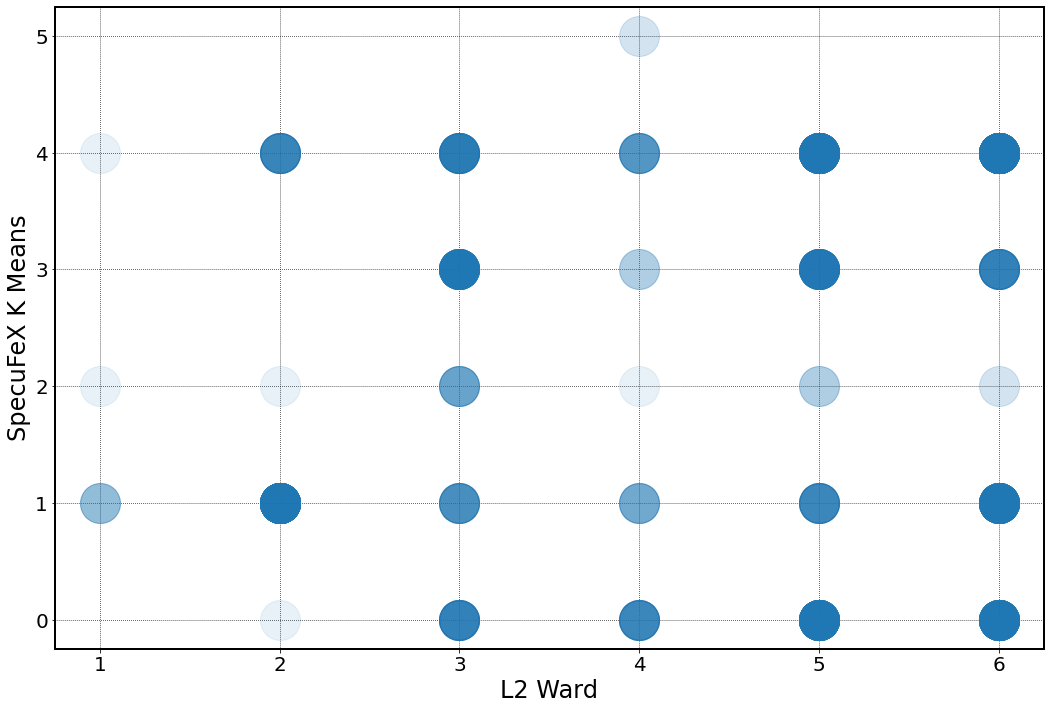

In [75]:
plt.plot(df_merged_sub.ward_L2_Dist,df_merged_sub.NC_6_CO2,'o',markersize=40,alpha=0.1)
plt.xlabel('L2 Ward')
plt.ylabel('SpecuFeX K Means')


## DTW data

In [33]:
resample_val = 1
path_to_save += '/'
df_merged.to_csv(path_to_save+'df_merged_base.csv')

In [34]:
path_to_save = 'A0_Results/DTW'

try : 
    os.mkdir(path_to_save)
except :
    print('exits')
path_to_save += '/'
df_merged.to_csv(path_to_save+'df_merged_base.csv')

In [35]:
gc.collect()

34

In [36]:
for exp_ID in np.unique(experiment_IDs):
    print(exp_ID)
    f1 = os.path.isfile(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_DTW.npy") 
    time_vals = np.arange(0,num_events[exp_ID],resample_val)
    index_list,waveforms_subset = he.get_subset_waveforms_byexp(norm_waveforms,
                                                                    exp_ID,df_merged,set_max_val=True,select_subset=False,
                                                                 max_val_wave= num_events[exp_ID],sample_rate=resample_val)
    if f1 == False :
        DTW,DTW_time_med,DTW_time_95,DTW_corr,DTW_L2,DTW_Smin,DTW_L1,results,master_index_list = he.calc_corrmatrix_DTW(waveforms_subset,experiment_IDs,time_vals)
        try :
            os.mkdir(path_to_save+exp_ID)
        except:
            print('Exists')
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_DTW.npy", DTW)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_DTW_Smin.npy", DTW_Smin)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_TimeShift_DTWMed.npy", DTW_time_med)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_TimeShift_DTW95.npy", DTW_time_95)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_Corr_DTW.npy", DTW_corr)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_L2_DTW.npy", DTW_L2)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_L1_DTW.npy", DTW_L1)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_L2_DTW_Res_All.npy", results)
        np.save(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_L2_DTW_master_index_list.npy", master_index_list)



  0%|          | 0/189420 [00:00<?, ?it/s]

CO2_H2O
Using 12 cores


100%|██████████| 189420/189420 [38:40<00:00, 81.62it/s]


: 2321.23 s


In [38]:
df_merged

,level_0,date,index,timestamp,evID,Disp_mm,Sig_diff_MPa,Strain_ax,Temp,time_hr,...,Strain_strain_rate,Exp_Name,evIDs,index_Waveforms_List,Unnamed: 0,P_confining,P_fluid,P_confining_1min,P_fluid_1min,Index_Exp
0,0,2020-01-09 15:00:04.000000000,209,1578582004000000000,2020.009.630004.226804120,1.49281,6.0958,0.000000,78.1701,0.001111,...,0.000000,Dry,2020.009.630004.226804120,209,NaN,NaN,NaN,NaN,NaN,0
1,1,2020-01-09 15:00:04.000000000,210,1578582004000000000,2020.009.630004.226804888,1.49281,6.0958,0.000000,78.1701,0.001111,...,0.000000,Dry,2020.009.630004.226804888,210,NaN,NaN,NaN,NaN,NaN,1
2,2,2020-01-09 15:00:14.000000000,211,1578582014000000000,2020.009.630014.226814455,1.49564,6.0958,0.000037,78.1337,0.003889,...,0.000000,Dry,2020.009.630014.226814455,211,NaN,NaN,NaN,NaN,NaN,2
3,3,2020-01-09 15:00:19.000000000,212,1578582019000000000,2020.009.630019.226819059,1.49847,6.4767,0.000073,78.1337,0.005278,...,0.000000,Dry,2020.009.630019.226819059,212,NaN,NaN,NaN,NaN,NaN,3
4,4,2020-01-09 15:00:23.000000000,213,1578582023000000000,2020.009.630023.226823115,1.49989,6.4767,0.000092,78.1337,0.006389,...,0.000000,Dry,2020.009.630023.226823115,213,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,8770,1970-01-01 00:00:00.001054466,8786,1054466,1054466346,3.63511,135.5950,0.046640,NaN,287.395833,...,0.258179,CO2_H2O_Open,1054466346,7599,8786.0,56.6773,6.0179,56.67645,6.016767,14647
14648,8771,1970-01-01 00:00:00.001054469,8787,1054469,1054469162,3.63511,135.5950,0.046640,NaN,287.396667,...,0.258179,CO2_H2O_Open,1054469162,7600,8787.0,56.6773,6.0179,56.67645,6.016767,14648
14649,8772,1970-01-01 00:00:00.001054555,8788,1054555,1054555135,3.64077,135.5950,0.046712,NaN,287.420556,...,0.266527,CO2_H2O_Open,1054555135,7601,8788.0,56.6773,6.0179,56.67730,6.017900,14649
14650,8773,1970-01-01 00:00:00.001054757,8789,1054757,1054757875,3.65351,135.5950,0.046876,NaN,287.476667,...,NaN,CO2_H2O_Open,1054757875,7602,8789.0,56.6773,6.0179,NaN,NaN,14650


In [40]:
plt.ioff()
for exp_ID in np.unique(experiment_IDs[5262]):
    #exp_ID = '25_tiepie'
    print('\n')
    print(exp_ID,num_events[exp_ID])
    print('\n')
    time_vals = np.arange(0,num_events[exp_ID],resample_val)
    index_list,waveforms_subset = he.get_subset_waveforms_byexp(norm_waveforms,
                                                                    exp_ID,df_merged,set_max_val=True,
                                                                 max_val_wave= num_events[exp_ID],sample_rate=resample_val)
    var1 = 'Sig_diff_MPa_1min'
    var2 = 'strain_rate'
    n_clust = 5
    #n_clust_all = np.array([4,5,6,7,8])
    #methods_all = np.array(['average','centroid','median','ward'])
    #methods_all = np.array(['median','ward'])
    methods_all = np.array(['ward'])
    evIDs_int  = index_list.copy()
    df_merged_sub = df_merged.loc[df_merged['Index_Exp'].isin(evIDs_int),:]
    length_waveforms = waveforms_subset[0].shape[0]
    
    DTW = np.load(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_DTW.npy")
    DTW_Smin = np.load(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_DTW_Smin.npy")
    DTW_time_med = np.load(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_TimeShift_DTWMed.npy")
    DTW_time_95 = np.load(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_TimeShift_DTW95.npy")
    DTW_corr = np.load(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_Corr_DTW.npy")
    DTW_L2 = np.load(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_L2_DTW.npy")
    DTW_L1 = np.load(path_to_save+exp_ID+"/Normalized_New_Processed_correlation_matrix_L1_DTW.npy")
        
    def make_Plot_Complement(A,df_merged_sub,name):
        try  :
            os.mkdir(path_to_save+exp_ID+name)
        except:
            print('exists')
        he.plot_matrix(df_merged,evIDs_int,var1,var2,A,np.median(A),num_values_side_bar=int(len(evIDs_int)/10))
        plt.savefig(path_to_save+exp_ID+name+f"/Matrix_{var1}_{var2}.png")
        plt.close('all')

        for method_use in methods_all :
            cluster_name = 'DTW_'+method_use+'_'+name.split("/")[1]
            print(name,method_use,cluster_name)
            g = he.plot_cluster(df_merged,evIDs_int,var1,var2,A,np.median(A),vmin=0,vmax=1000,vmin_use = False,method=method_use)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_MatrixCluster_{var1}_{var2}.png")
            #plt.close('all')
    #         for n_clust in n_clust_all :
    #             print(n_clust)
    #             df_merged_sub = get_clust(df_merged_sub,int(n_clust),g)
    #             plt.savefig(path_to_save+exp_ID+name+f"/Matrix_Dendrogram.png")
    #             get_silloute_scores(A,df_merged_sub['cluster'].values,n_clust)        
            df_merged_sub = he.get_clust(df_merged_sub,int(n_clust),g,
                                         path_to_save+exp_ID+name+f"/{method_use}_File_Cluster_Info.txt",
                                         cluster_name)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Matrix_Dendrogram.png")
            he.Plot_clust_time(cluster_name,df_merged_sub)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Time_Sequence.png")
            plt.close('all')

            he.make_plot_Dist(cluster_name,df_merged_sub,var1)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}.png")
            plt.close()
            he.make_plot_Dist(cluster_name,df_merged_sub,var2)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var2}_Distance.png")
            plt.close()
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var2}.png")
            plt.close()
            he.make_plot_Cross(cluster_name,df_merged_sub,var1,var2)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Distribution_{var1}_{var2}.png")

            plt.close('all')
            he.get_representative_waveforms(cluster_name,norm_waveforms,time_vals,n_clust,df_merged_sub,index_list,num_events=40,is_DTW=True,cross_corr=False,
                                         max_time_indx=int(num_events[exp_ID]*1.05),max_val_time_wave=length_waveforms,resample_rate=resample_val)
            plt.figure(10)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Waveforms_Original.png")
            plt.figure(11)
            plt.savefig(path_to_save+exp_ID+name+f"/{method_use}_Cluster_Waveforms_TimeShifted.png")
            plt.close('all')
            df_merged_sub.to_csv(path_to_save+exp_ID+name+f'/{method_use}_df_merged_sub.csv')
            gc.collect()
        return df_merged_sub
    
    df_merged_sub = make_Plot_Complement(DTW_L2,df_merged_sub,'/DTW_L2')
    df_merged_sub = make_Plot_Complement(DTW_corr,df_merged_sub,'/DTW_corr')
    df_merged_sub = make_Plot_Complement(DTW_Smin,df_merged_sub,'/DTW_Smin')
    df_merged_sub = make_Plot_Complement(DTW,df_merged_sub,'/DTW')
    df_merged_sub = make_Plot_Complement(DTW_time_med,df_merged_sub,'/DTW_time_med')
    df_merged_sub = make_Plot_Complement(DTW_time_95,df_merged_sub,'/DTW_time_95')  
    df_merged_sub = make_Plot_Complement(DTW_L1,df_merged_sub,'/DTW_L1')
    df_merged_sub.to_csv(path_to_save+exp_ID+f'/df_merged_sub.csv')
    
plt.ion()



CO2_H2O 1000


exists
/DTW_L2 ward DTW_ward_DTW_L2
exists
/DTW_corr ward DTW_ward_DTW_corr
exists
/DTW_Smin ward DTW_ward_DTW_Smin
exists
/DTW ward DTW_ward_DTW
exists
/DTW_time_med ward DTW_ward_DTW_time_med
exists
/DTW_time_95 ward DTW_ward_DTW_time_95
/DTW_L1 ward DTW_ward_DTW_L1
